## 🚖 NYC Taxi Trip Duration Prediction

### Advanced Mobility Analytics with XGBoost & K-Means Clustering

### 📖 Overview
In the logistics and mobility sector, accurate time estimation is the cornerstone of fleet efficiency and user satisfaction. This project analyzes over 1.4 million taxi trips in New York City to predict the total trip duration.

Unlike standard regression approaches, this project utilizes Spatial Clustering (K-Means) to define functional traffic zones and Cyclical Temporal Encoding to capture the continuous nature of time, resulting in a highly competitive RMSLE score.

Dataset: https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
df = pd.read_csv('train.csv')
df.sample(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
949968,id0022854,2,2016-06-21 17:31:17,2016-06-21 17:39:32,1,-73.958916,40.773209,-73.969284,40.763561,N,495
334978,id2282465,2,2016-06-01 19:55:47,2016-06-01 20:11:59,1,-73.984138,40.759235,-73.980606,40.737732,N,972
28855,id1503507,1,2016-02-01 13:21:18,2016-02-01 13:39:21,1,-73.967842,40.762596,-73.994850,40.745277,N,1083
415149,id2552103,2,2016-03-23 08:14:54,2016-03-23 08:23:20,1,-73.976784,40.736092,-73.954880,40.765251,N,506
70903,id1116194,1,2016-01-14 14:03:12,2016-01-14 14:10:26,1,-73.972824,40.795887,-73.956757,40.784901,N,434


In [98]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [99]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [101]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [102]:
df['trip_duration_minutes'] = df['trip_duration']/60

In [103]:
# calculating the distance between the pickup and dropoff coordination:

def manhattan_distance_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    # Convert to radians (works on Series)
    lat1, lon1, lat2, lon2 = np.radians(lat1), np.radians(lon1), np.radians(lat2), np.radians(lon2)

    # 1. Calculate North-South distance (change in latitude only)
    dlat = lat2 - lat1
    a1 = np.sin(dlat/2)**2
    c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
    dist_ns = R * c1

    # 2. Calculate East-West distance (change in longitude only)
    # Use average latitude for the calculation
    avg_lat = (lat1 + lat2) / 2
    dlon = lon2 - lon1
    a2 = np.cos(avg_lat)**2 * np.sin(dlon/2)**2
    c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
    dist_ew = R * c2

    # Manhattan distance is the sum
    return dist_ns + dist_ew

In [104]:
df['manhattan_dist_km'] = manhattan_distance_vectorized(
    df['pickup_latitude'], 
    df['pickup_longitude'], 
    df['dropoff_latitude'], 
    df['dropoff_longitude']
)

In [105]:
df['avg_velocity_km/hr'] = df['manhattan_dist_km']/(df['trip_duration_minutes']/60)

In [106]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06
trip_duration_minutes,1458644.0,15.991538,87.290529,0.016667,6.616667,11.033333,17.916667,5.877137e+04
manhattan_dist_km,1458644.0,4.446757,5.663053,0.000000,1.570938,2.688791,4.998912,1.328090e+03
avg_velocity_km/hr,1458644.0,18.649507,20.192776,0.000000,11.508421,16.351802,23.146064,1.311178e+04


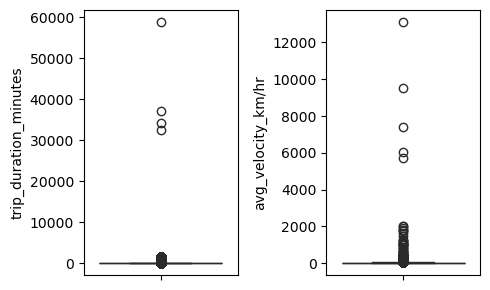

In [107]:
plt.figure(figsize=(5,3))
plt.subplot(1,2,1)
sns.boxplot(data=df, y='trip_duration_minutes', color='darkred')

plt.subplot(1,2,2)
sns.boxplot(data=df, y='avg_velocity_km/hr', color='darkred')

plt.tight_layout()
plt.show()

##### many outliers are there in the boxplots! now checking the trips duration more than 120 minutes:

In [108]:
df[df['trip_duration_minutes']>120].sort_values(by='manhattan_dist_km', ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr
114376,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.455917,39.803932,-73.796021,40.707726,N,23440,390.666667,241.354470,37.068093
1301396,id1216866,1,2016-03-26 22:01:54,2016-03-27 00:47:16,1,-73.981491,40.773251,-76.135719,40.243626,N,9922,165.366667,241.011240,87.446126
1416336,id3795134,1,2016-03-21 20:54:00,2016-03-22 01:43:23,3,-75.238327,39.923027,-73.922577,40.610130,N,17363,289.383333,188.038542,38.987430
191797,id3759923,2,2016-03-11 14:51:43,2016-03-11 17:37:55,1,-73.790054,40.646801,-74.602432,40.338867,N,9972,166.200000,102.936994,37.161370
936006,id2510396,1,2016-01-26 06:58:16,2016-01-26 10:01:01,2,-73.789886,40.646503,-74.458847,40.797791,N,10965,182.750000,73.197305,24.031947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551398,id0385849,2,2016-04-04 13:03:06,2016-04-05 12:03:23,1,-73.927917,40.747311,-73.927917,40.747299,N,82817,1380.283333,0.001273,0.000055
822586,id0759846,2,2016-06-22 08:56:20,2016-06-23 08:55:02,1,-73.936562,40.764900,-73.936569,40.764900,N,86322,1438.700000,0.000643,0.000027
168983,id2177467,2,2016-06-05 01:09:39,2016-06-06 01:08:51,1,-73.981407,40.764969,-73.981407,40.764969,N,86352,1439.200000,0.000000,0.000000
120183,id3070191,2,2016-01-01 15:27:28,2016-01-02 15:09:41,3,-73.989655,40.735657,-73.989655,40.735657,N,85333,1422.216667,0.000000,0.000000


In [109]:
df[df['avg_velocity_km/hr']>120].sort_values(by='avg_velocity_km/hr', ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr
1176337,id3619353,2,2016-02-13 20:28:30,2016-02-13 20:28:37,1,-73.936974,40.764610,-73.789848,40.646858,N,7,0.116667,25.495124,13111.778085
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,N,303,5.050000,801.377026,9521.311196
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,N,611,10.183333,1259.225276,7419.330593
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,13.200000,1328.089672,6036.771235
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,282,4.700000,449.348934,5736.369372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106987,id1420042,2,2016-06-27 00:37:20,2016-06-27 00:37:50,2,-73.979805,40.752026,-73.975380,40.757812,N,30,0.500000,1.016200,121.944049
1034341,id0218424,1,2016-01-17 13:50:16,2016-01-17 13:50:17,1,-73.953728,40.670036,-73.953346,40.670021,N,1,0.016667,0.033869,121.929575
983396,id3874299,1,2016-03-26 17:19:48,2016-03-26 17:20:02,1,-74.135498,40.902103,-74.140175,40.901379,N,14,0.233333,0.473656,121.797212
975491,id0262923,2,2016-03-19 03:55:17,2016-03-19 03:55:29,5,-74.009430,40.738110,-74.006317,40.739391,N,12,0.200000,0.404781,121.434205


In [110]:
df[df['manhattan_dist_km']>120].sort_values(by='manhattan_dist_km', ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,13.200000,1328.089672,6036.771235
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,N,611,10.183333,1259.225276,7419.330593
1100676,id2644780,1,2016-05-03 16:24:07,2016-05-03 17:18:34,2,-73.991325,40.750023,-79.518616,43.921028,N,3267,54.450000,806.845382,889.085820
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,N,303,5.050000,801.377026,9521.311196
923793,id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.972366,40.758633,-79.553535,43.674000,N,1405,23.416667,783.714843,2008.094972
397526,id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.870682,40.773598,-79.817978,38.963852,N,2515,41.916667,708.705677,1014.449478
1013474,id3626673,1,2016-05-05 18:02:50,2016-05-05 18:18:23,1,-73.978912,40.756763,-79.338699,41.427902,N,933,15.550000,523.718421,2020.778473
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,282,4.700000,449.348934,5736.369372
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,N,875,14.583333,422.415721,1737.938968
1060807,id0838705,1,2016-02-26 19:50:03,2016-02-26 20:08:54,1,-66.972160,44.371944,-69.048019,43.147583,N,1131,18.850000,302.850873,963.981558


#### by checking manually on the google map, you'll find out most of these data from the table above are outliers, so we need to set the boundries to analyse the trips JUST WITHIN the NYC.

In [111]:
# just in new york

xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]

df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

now check again:

In [112]:
df[df['manhattan_dist_km']>120].sort_values(by='manhattan_dist_km', ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr


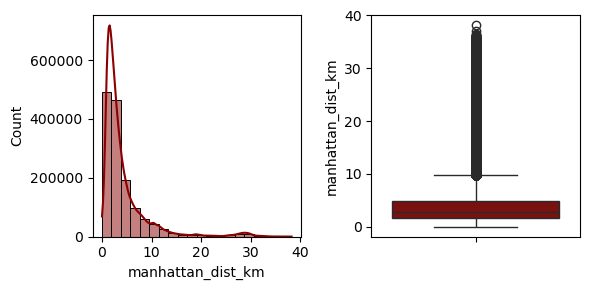

In [113]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
sns.histplot(data=df, x='manhattan_dist_km', bins=20, kde=True, color='darkred')

plt.subplot(1,2,2)
sns.boxplot(data=df, y='manhattan_dist_km', color='darkred')

plt.tight_layout()
plt.show()

now it makes sense! all good!

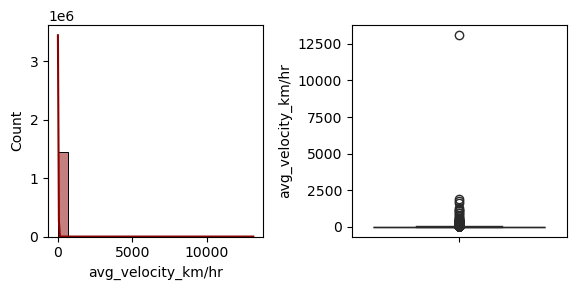

In [114]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
sns.histplot(data=df, x='avg_velocity_km/hr', bins=20, kde=True, color='darkred')

plt.subplot(1,2,2)
sns.boxplot(data=df, y='avg_velocity_km/hr', color='darkred')

plt.tight_layout()
plt.show()

##### again there are outliers!

In [115]:
df[df['avg_velocity_km/hr']==0].sort_values(by='avg_velocity_km/hr', ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,3.783333,0.0,0.0
958624,id3072359,2,2016-02-05 10:18:14,2016-02-05 10:22:53,1,-73.983963,40.717419,-73.983963,40.717419,N,279,4.650000,0.0,0.0
958274,id2952970,2,2016-04-09 19:40:13,2016-04-09 19:54:39,1,-73.863243,40.769409,-73.863243,40.769409,N,866,14.433333,0.0,0.0
958142,id3713791,1,2016-05-08 23:44:47,2016-05-08 23:45:22,1,-73.924088,40.697376,-73.924088,40.697376,N,35,0.583333,0.0,0.0
957962,id3183612,2,2016-05-14 02:57:02,2016-05-14 03:12:14,1,-73.981018,40.741795,-73.981018,40.741795,N,912,15.200000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479747,id3597833,2,2016-06-01 16:27:25,2016-06-01 16:43:01,1,-73.916977,40.837051,-73.916977,40.837051,N,936,15.600000,0.0,0.0
479605,id0609077,2,2016-04-02 17:33:37,2016-04-02 17:42:07,2,-74.011353,40.701527,-74.011353,40.701527,N,510,8.500000,0.0,0.0
479557,id0618043,1,2016-01-21 11:03:38,2016-01-21 11:20:47,2,-73.954666,40.821003,-73.954666,40.821003,Y,1029,17.150000,0.0,0.0
479469,id1986591,2,2016-03-07 09:59:27,2016-03-07 10:18:34,1,-73.940681,40.830330,-73.940681,40.830330,N,1147,19.116667,0.0,0.0


there are many trips that the pickup long/lat is exactly equal to dropoff long/lat. it means there is no moving or there is error on data collection. we should remove them :(

In [116]:
df = df[df['avg_velocity_km/hr']>0]

In [117]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,1.735459,13.731106
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,2.430596,13.197804
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,8.204472,13.905885
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,1.661350,13.941398
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,1.199458,9.926546


In [118]:
df.shape

(1433252, 14)

In [119]:
df[df['avg_velocity_km/hr']>100].sort_values(by='avg_velocity_km/hr', ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr
1176337,id3619353,2,2016-02-13 20:28:30,2016-02-13 20:28:37,1,-73.936974,40.764610,-73.789848,40.646858,N,7,0.116667,25.495124,13111.778085
906281,id1935555,2,2016-06-19 20:18:35,2016-06-19 20:19:26,1,-73.781860,40.644657,-73.993690,40.724537,N,51,0.850000,26.743776,1887.795931
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,2,0.033333,0.992611,1786.700384
898154,id1859761,2,2016-05-28 15:14:19,2016-05-28 15:14:39,1,-73.815674,40.700844,-73.783714,40.643608,N,20,0.333333,9.059655,1630.737947
259403,id2507444,2,2016-01-27 09:03:12,2016-01-27 09:03:22,1,-73.807419,40.657215,-73.783249,40.643806,N,10,0.166667,3.530029,1270.810515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562945,id2698115,2,2016-05-22 07:50:03,2016-05-22 07:50:08,1,-73.982269,40.773998,-73.983368,40.774426,N,5,0.083333,0.140020,100.814289
1222166,id1642256,2,2016-02-16 17:36:35,2016-02-16 17:36:40,1,-73.950768,40.777599,-73.949677,40.777168,N,5,0.083333,0.139797,100.653975
47467,id0781449,2,2016-03-28 21:09:30,2016-03-28 21:09:35,1,-73.783676,40.646366,-73.784729,40.645908,N,5,0.083333,0.139729,100.605063
515334,id0178585,2,2016-02-15 18:36:27,2016-02-15 18:36:35,1,-73.975098,40.757381,-73.973083,40.756901,N,8,0.133333,0.223095,100.392933


##### as we can see there are outliers for the velocities higher than 100 km/h. (based on the search on the web, the speed limit is 55 mph in NYC). so again, we should remove them :(

In [120]:
df = df[df['avg_velocity_km/hr'] <= 90]

In [121]:
df.shape

(1432960, 14)

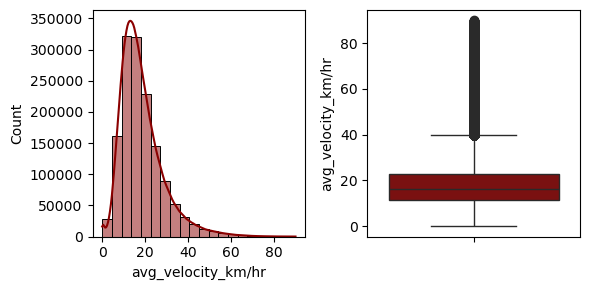

In [122]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
sns.histplot(data=df, x='avg_velocity_km/hr', bins=20, kde=True, color='darkred')

plt.subplot(1,2,2)
sns.boxplot(data=df, y='avg_velocity_km/hr', color='darkred')

plt.tight_layout()
plt.show()

now it makes sense!

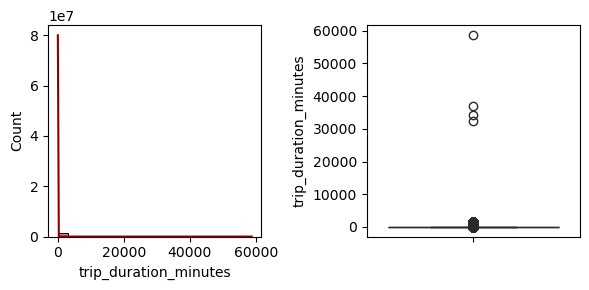

In [123]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
sns.histplot(data=df, x='trip_duration_minutes', bins=20, kde=True, color='darkred')

plt.subplot(1,2,2)
sns.boxplot(data=df, y='trip_duration_minutes', color='darkred')

plt.tight_layout()
plt.show()

In [124]:
df[df['trip_duration_minutes']>150].sort_values(by='avg_velocity_km/hr', ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr
259713,id1357675,1,2016-04-15 17:49:41,2016-04-15 20:35:03,4,-73.782234,40.644501,-74.029587,40.747803,N,9922,165.366667,32.339852,11.733871
821202,id3602082,1,2016-02-06 09:11:42,2016-02-06 11:44:17,1,-73.790184,40.646881,-73.989380,40.760166,N,9155,152.583333,29.388182,11.556248
230581,id1628821,1,2016-05-15 17:16:32,2016-05-15 19:57:48,1,-73.783203,40.648609,-73.992882,40.756882,N,9676,161.266667,29.714681,11.055483
133723,id0930106,2,2016-02-29 12:54:31,2016-02-29 15:27:23,1,-73.791573,40.645233,-73.991829,40.746456,N,9172,152.866667,28.138281,11.044245
1049365,id1718005,2,2016-04-07 14:42:52,2016-04-07 17:15:11,5,-73.976898,40.764439,-73.790459,40.654259,N,9139,152.316667,27.966217,11.016346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308994,id2191163,2,2016-06-08 20:09:16,2016-06-09 17:48:05,1,-73.991898,40.714981,-73.991844,40.714989,N,77929,1298.816667,0.005349,0.000247
62744,id3917283,2,2016-06-06 16:39:09,2016-06-07 16:30:50,0,-73.776367,40.645248,-73.776360,40.645260,N,85901,1431.683333,0.001916,0.000080
780672,id2550069,2,2016-03-23 17:20:28,2016-03-24 15:53:53,1,-73.782745,40.644024,-73.782753,40.644016,N,81205,1353.416667,0.001492,0.000066
551398,id0385849,2,2016-04-04 13:03:06,2016-04-05 12:03:23,1,-73.927917,40.747311,-73.927917,40.747299,N,82817,1380.283333,0.001273,0.000055


##### as we can see, there are some outliers that the trip duration is so high, they don't make sense! we remove trips took more than 150 minutes.

In [125]:
df = df[df['trip_duration_minutes']<=120]

In [126]:
df.shape

(1430773, 14)

##### the final check on the distribution of the dataset to ensure everything is ok:

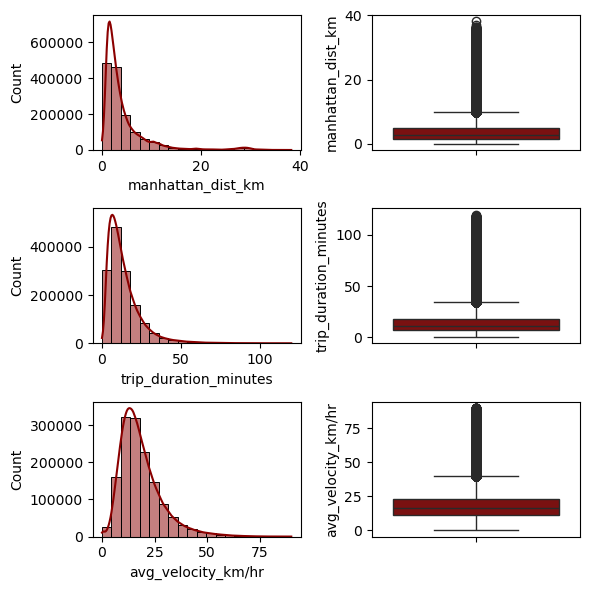

In [127]:
plt.figure(figsize=(6,6))

plt.subplot(3,2,1)
sns.histplot(data=df, x='manhattan_dist_km', bins=20, kde=True, color='darkred')

plt.subplot(3,2,2)
sns.boxplot(data=df, y='manhattan_dist_km', color='darkred')

plt.subplot(3,2,3)
sns.histplot(data=df, x='trip_duration_minutes', bins=20, kde=True, color='darkred')

plt.subplot(3,2,4)
sns.boxplot(data=df, y='trip_duration_minutes', color='darkred')

plt.subplot(3,2,5)
sns.histplot(data=df, x='avg_velocity_km/hr', bins=20, kde=True, color='darkred')

plt.subplot(3,2,6)
sns.boxplot(data=df, y='avg_velocity_km/hr', color='darkred')

plt.tight_layout()
plt.show()

#### All good! let's analyze the spatio-temporal aspects:

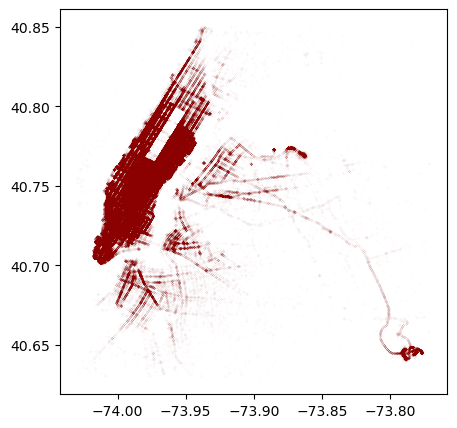

In [128]:
plt.figure(figsize = (5,5))
plt.plot(df['pickup_longitude'], df['pickup_latitude'],'.', alpha = 0.5, markersize = 0.05, color='darkred')
plt.show()

In [131]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [132]:
df['pickup_datetime_year'] = df['pickup_datetime'].dt.year

In [133]:
df['pickup_datetime_month'] = df['pickup_datetime'].dt.month

In [134]:
df['pickup_datetime_day'] = df['pickup_datetime'].dt.day

In [135]:
df['pickup_datetime_hour'] = df['pickup_datetime'].dt.hour

In [136]:
df['pickup_datetime_year'].unique()

array([2016])

In [137]:
df['pickup_datetime_month'].unique()

array([3, 6, 1, 4, 5, 2])

In [138]:
df['pickup_datetime_day'].unique()

array([14, 12, 19,  6, 26, 30, 17, 21, 27, 10, 15,  1, 16, 11,  5, 28,  9,
       25,  3, 20, 13, 23, 18,  7,  2, 22, 29, 24, 31,  4,  8])

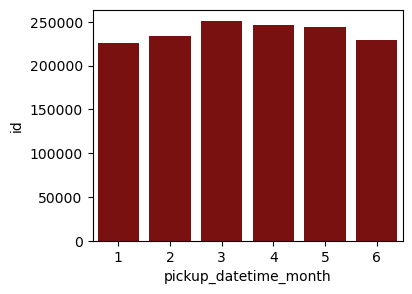

   pickup_datetime_month      id
0                      1  225387
1                      2  234037
2                      3  251395
3                      4  246782
4                      5  243506
5                      6  229666


In [139]:
group_month = df.groupby('pickup_datetime_month')['id'].count()
group_month_df = group_month.reset_index()

plt.figure(figsize=(4,3))
sns.barplot(data=group_month_df, x='pickup_datetime_month', y='id', color='darkred')
plt.show()

print(group_month_df)

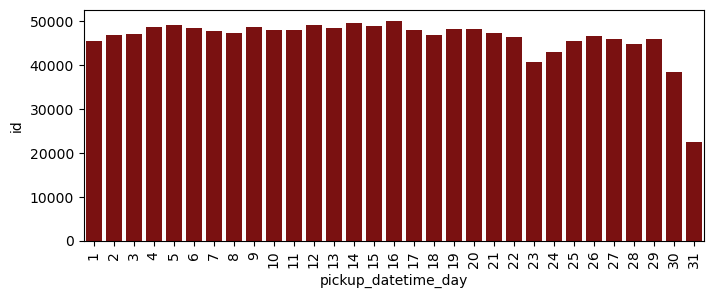

    pickup_datetime_day     id
0                     1  45611
1                     2  46864
2                     3  47023
3                     4  48695
4                     5  49236
5                     6  48556
6                     7  47812
7                     8  47329
8                     9  48706
9                    10  47918
10                   11  47977
11                   12  49162
12                   13  48407
13                   14  49594
14                   15  48865
15                   16  50106
16                   17  47939
17                   18  46952
18                   19  48345
19                   20  48286
20                   21  47325
21                   22  46345
22                   23  40660
23                   24  42971
24                   25  45563
25                   26  46655
26                   27  46075
27                   28  44926
28                   29  45915
29                   30  38394
30                   31  22561


In [140]:
group_day = df.groupby('pickup_datetime_day')['id'].count()
group_day_df = group_day.reset_index()

plt.figure(figsize=(8,3))
sns.barplot(data=group_day_df, x='pickup_datetime_day', y='id', color='darkred')
plt.xticks(rotation=90)
plt.show()

print(group_day_df)

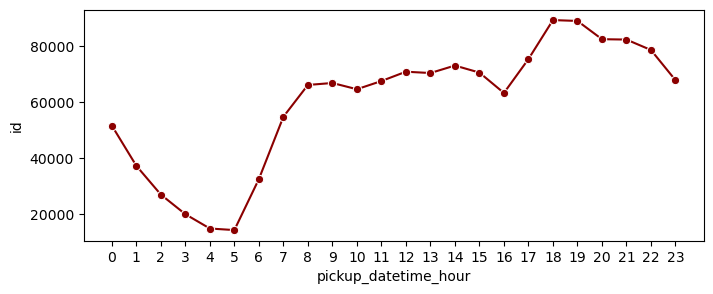

    pickup_datetime_hour     id
0                      0  51656
1                      1  37335
2                      2  27082
3                      3  20102
4                      4  15001
5                      5  14442
6                      6  32598
7                      7  54790
8                      8  66127
9                      9  66829
10                    10  64604
11                    11  67521
12                    12  70845
13                    13  70375
14                    14  73039
15                    15  70534
16                    16  63276
17                    17  75339
18                    18  89233
19                    19  88924
20                    20  82427
21                    21  82292
22                    22  78574
23                    23  67828


In [141]:
group_hour = df.groupby('pickup_datetime_hour')['id'].count()
group_hour_df = group_hour.reset_index()

plt.figure(figsize=(8,3))
sns.lineplot(data=group_hour_df, x='pickup_datetime_hour', y='id', color='darkred', marker='o')
plt.xticks(group_hour_df.index)
plt.show()

print(group_hour_df)

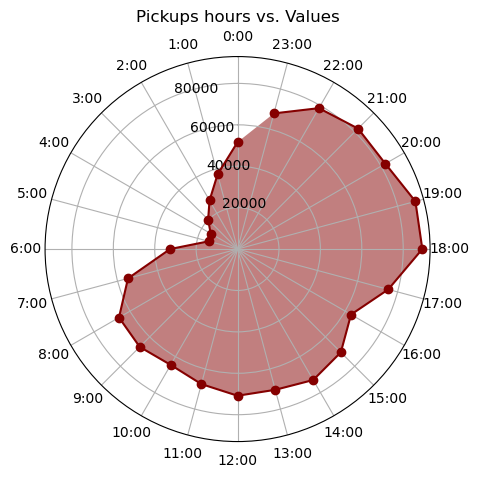

In [142]:

plt.figure(figsize=(5, 5))


# Create a polar plot
ax = plt.subplot(111, projection='polar')

# Convert hours to radians
hours_in_radians = np.deg2rad((group_hour.index) * 360 / 24)

# Plot values
ax.plot(hours_in_radians, group_hour.values, marker='o', linestyle='-', color='#850000')

# Set radial axis labels to show hours
ax.set_xticks(hours_in_radians)
ax.set_xticklabels([str(hour) + ':00' for hour in group_hour.index])
ax.set_theta_offset(np.pi/2)

# Fill the space between the data points
ax.fill(hours_in_radians, group_hour.values, '#850000', alpha=0.5)  # Adjust alpha for transparency ---> #850000 is dark red.

# Add a title
ax.set_title('Pickups hours vs. Values')

# Show the polar plot
plt.show()

In [143]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# --- PHASE 1: CLUSTERING (CORRECTED SECTION) ---

# 1. Prepare Data for Clustering (FIT on Pickup Coordinates)
coords = df[['pickup_latitude', 'pickup_longitude']].copy()
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# 2. Apply K-Means (K=15 Zones)
K = 15
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans.fit(coords_scaled)

# 3. Assign Cluster Labels to DataFrames
# Pickup clusters (This part was correct)
df['pickup_cluster'] = kmeans.predict(coords_scaled)

# Dropoff clusters: CORRECTED STEPS
dropoff_coords = df[['dropoff_latitude', 'dropoff_longitude']].copy()

# RENAME columns to match the features the scaler/model were fitted on (pickup_*)
dropoff_coords.columns = ['pickup_latitude', 'pickup_longitude'] 

# Now transform and predict
dropoff_coords_scaled = scaler.transform(dropoff_coords)
df['dropoff_cluster'] = kmeans.predict(dropoff_coords_scaled)

# --- The rest of your code (adding centroids and aggregating) can follow ---
print(f"Clustering complete. {K} zones defined.")

# --- PHASE 2: AGGREGATE NEW CLUSTER FLOW DATA ---

# 1. Create a DataFrame for flow aggregation
cluster_flow_data = df.groupby(['pickup_cluster', 'dropoff_cluster', 'pickup_datetime_hour']).agg(
    trip_count=('id', 'count')
).reset_index()

# 2. Add Cluster Centroids (The coordinates for your desire lines)
# The centroids are stored in the K-Means object, but they are SCALED. We must inverse transform them.
centroids_unscaled = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids_unscaled, columns=['centroid_lat', 'centroid_lon'])
centroids_df['cluster_id'] = centroids_df.index

# 3. Merge Centroids into Flow Data (Twice: once for origin, once for destination)
cluster_flow_data = cluster_flow_data.merge(
    centroids_df.rename(columns={'cluster_id': 'pickup_cluster'}), 
    on='pickup_cluster', 
    how='left'
)
cluster_flow_data = cluster_flow_data.merge(
    centroids_df.rename(columns={'cluster_id': 'dropoff_cluster', 
                                 'centroid_lat': 'dropoff_centroid_lat',
                                 'centroid_lon': 'dropoff_centroid_lon'}), 
    on='dropoff_cluster', 
    how='left'
)

# 4. Final Cleanup for Visualization
# Log transform the trip count for line width scaling (crucial for visual clarity)
cluster_flow_data['log_trip_count'] = np.log1p(cluster_flow_data['trip_count'])

cluster_flow_data.to_csv('cluster_flow_data.csv', index=False)
print("\n--- New Cluster Flow Data Head ---")
print(cluster_flow_data.head())
print("\n[File cluster_flow_data.csv created for cluster-based flow analysis.]")

Clustering complete. 15 zones defined.

--- New Cluster Flow Data Head ---
   pickup_cluster  dropoff_cluster  pickup_datetime_hour  trip_count  \
0               0                0                     0         724   
1               0                0                     1         518   
2               0                0                     2         441   
3               0                0                     3         364   
4               0                0                     4         303   

   centroid_lat  centroid_lon  dropoff_centroid_lat  dropoff_centroid_lon  \
0     40.752113    -73.993136             40.752113            -73.993136   
1     40.752113    -73.993136             40.752113            -73.993136   
2     40.752113    -73.993136             40.752113            -73.993136   
3     40.752113    -73.993136             40.752113            -73.993136   
4     40.752113    -73.993136             40.752113            -73.993136   

   log_trip_count  
0        

In [144]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes,manhattan_dist_km,avg_velocity_km/hr,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_hour,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,1.735459,13.731106,2016,3,14,17,6,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,2.430596,13.197804,2016,6,12,0,7,12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,8.204472,13.905885,2016,1,19,11,6,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,1.661350,13.941398,2016,4,6,19,4,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,1.199458,9.926546,2016,3,26,13,13,13


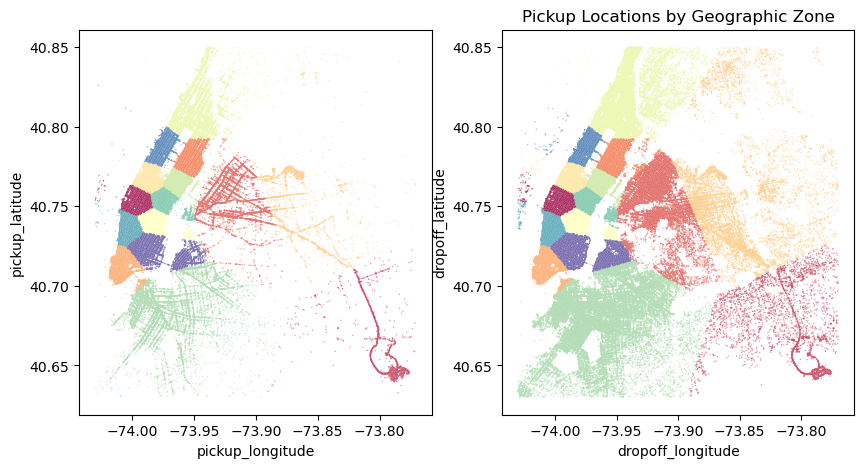

In [145]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.scatterplot(
    data=df,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='pickup_cluster', 
    s=1,        
    alpha=0.5,  
    legend=False,
    palette='Spectral'
)

plt.subplot(1,2,2)
sns.scatterplot(
    data=df,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='dropoff_cluster', 
    s=1,        
    alpha=0.5,  
    legend=False,
    palette='Spectral'
)

plt.title('Pickup Locations by Geographic Zone')
plt.show()

In [146]:
import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def lnglat_to_mercator(lng, lat):
    r = 6378137.000
    x = r * np.radians(lng)
    scale = x / lng
    y = 180.0 / np.pi * np.log(np.tan(np.pi / 4.0 + lat * (np.pi / 180.0) / 2.0)) * scale
    return x, y


# --- 4. Prepare Network Data & Convert to Web Mercator ---
# Get Centroids (Lat/Lon)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=['lat', 'lon'])
centroid_df['cluster_id'] = centroid_df.index

# CONVERT Centroids to Web Mercator (The Fix!)
centroid_df['x'], centroid_df['y'] = lnglat_to_mercator(centroid_df['lon'], centroid_df['lat'])

# Aggregate Flow
flow = df.groupby(['pickup_datetime_hour', 'pickup_cluster', 'dropoff_cluster']).size().reset_index(name='trips')
flow = flow.merge(centroid_df, left_on='pickup_cluster', right_on='cluster_id')
flow.rename(columns={'x': 'start_x', 'y': 'start_y'}, inplace=True)
flow = flow.merge(centroid_df, left_on='dropoff_cluster', right_on='cluster_id')
flow.rename(columns={'x': 'end_x', 'y': 'end_y'}, inplace=True)
flow = flow[flow['pickup_cluster'] != flow['dropoff_cluster']]

# Calculate width scaling
flow['width'] = np.log1p(flow['trips'])
max_width = flow['width'].max()

# --- 5. Generate Animation Frames with Map Background ---
print("Generating frames...")

# Define the bounds in Mercator (The Fix!)
nyc_min_x, nyc_min_y = lnglat_to_mercator(-74.03, 40.63)
nyc_max_x, nyc_max_y = lnglat_to_mercator(-73.77, 40.85)

for hour in range(24):
    # Create larger figure for high-quality map
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # 1. Plot the Map Tiles (Geographical Layer)
    # We force the axis limits to the NYC Mercator coordinates calculated above
    ax.set_xlim(nyc_min_x, nyc_max_x)
    ax.set_ylim(nyc_min_y, nyc_max_y)
    
    # Add the map background (CartoDB Positron is clean and professional)
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Could not fetch map tiles: {e}. Check internet connection.")

    # 2. Draw Static Nodes (Centroids)
    ax.scatter(centroid_df['x'], centroid_df['y'], s=200, c='red', edgecolors='white', zorder=5, alpha=0.9)

    # 3. Draw Dynamic Flows (Arrows)
    hour_data = flow[flow['pickup_datetime_hour'] == hour]
    threshold = hour_data['trips'].quantile(0.50) 
    top_flows = hour_data[hour_data['trips'] > threshold]

    for _, row in top_flows.iterrows():
        alpha = min(1.0, 0.3 + (row['width'] / max_width) * 0.7)
        linewidth = (row['width'] / max_width) * 5
        
        # Arrows use Mercator coordinates (start_x, start_y)
        ax.arrow(
            row['start_x'], row['start_y'], 
            row['end_x'] - row['start_x'], row['end_y'] - row['start_y'],
            color='#0044cc', # Professional Blue
            alpha=alpha,
            width=30 * linewidth, 
            head_width=250, 
            length_includes_head=True,
            zorder=3
        )

    # Formatting
    ax.set_axis_off()
    ax.set_title(f"NYC Taxi Demand: {hour:02d}:00", fontsize=24, fontweight='bold', pad=20)
    
    # Save Frame
    plt.savefig(f'map_frame_{hour:02d}.png', dpi=100, bbox_inches='tight')
    plt.close(fig)

print("Done! Frames created. Stitch them together to see the flow on the map.")

Generating frames...
Done! Frames created. Stitch them together to see the flow on the map.


In [147]:
import imageio.v3 as iio
import os

# 1. Define the output filename
output_gif_name = 'nyc_mobility_flow.gif'

# 2. Locate and sort the frames
# We sort to ensure 00 comes before 01, etc.
# Adjust the prefix 'map_frame_' if you changed the filename in the previous step.
frames = sorted([f for f in os.listdir('.') if f.startswith('map_frame_') and f.endswith('.png')])

# Critical Check: Ensure frames exist before trying to build
if not frames:
    print("Error: No frames found. Please run the frame generation code first.")
else:
    print(f"Found {len(frames)} frames. Compiling GIF...")

    # 3. Read frames into memory
    images = [iio.imread(filename) for filename in frames]

    # 4. Write the GIF
    # duration=500 means 500ms (0.5 seconds) per frame.
    # loop=0 means loop forever.
    iio.imwrite(output_gif_name, images, duration=500, loop=0)

    print(f"Success! Animation saved as: {output_gif_name}")

Found 24 frames. Compiling GIF...
Success! Animation saved as: nyc_mobility_flow.gif


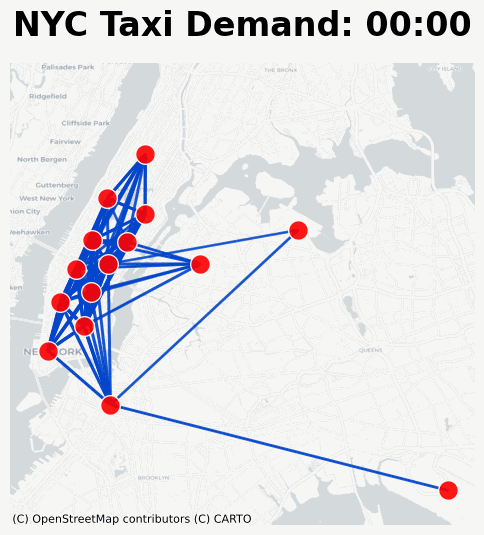

In [148]:
from IPython.display import Image
Image(filename='nyc_mobility_flow.gif')

##### preprocessing for model implemetation:

In [149]:
# converting the pickup_datetime_hour and pickup_datetime_month to cyclic features:

df['hour_sin'] = np.sin(2 * np.pi * df['pickup_datetime_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['pickup_datetime_hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['pickup_datetime_month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['pickup_datetime_month'] / 12)

In [150]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'trip_duration_minutes', 'manhattan_dist_km',
       'avg_velocity_km/hr', 'pickup_datetime_year', 'pickup_datetime_month',
       'pickup_datetime_day', 'pickup_datetime_hour', 'pickup_cluster',
       'dropoff_cluster', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [151]:
columns_to_drop = ['id', 'pickup_longitude', 'pickup_latitude', 'trip_duration', 
                   'trip_duration_minutes', 'avg_velocity_km/hr', 'dropoff_longitude', 'pickup_datetime_year',
                   'dropoff_latitude', 'pickup_datetime', 'dropoff_datetime', 'pickup_datetime_day', 
                   'pickup_datetime_month', 'pickup_datetime_hour']

numerical_cols = ['passenger_count', 'manhattan_dist_km',
                    'hour_sin', 'hour_cos', 'month_sin', 'month_cos']

categorical_cols = ['vendor_id', 'store_and_fwd_flag', 'pickup_cluster', 'dropoff_cluster']

##### we have done preprocessing for the test data, now we should do the exact steps we've done for train data on the test dataset:

In [152]:
df_test = pd.read_csv('test.csv')
df_test.shape

(625134, 9)

In [153]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [154]:
# preprocessing for test data

df_test['manhattan_dist_km'] = manhattan_distance_vectorized(
    df_test['pickup_latitude'], 
    df_test['pickup_longitude'], 
    df_test['dropoff_latitude'], 
    df_test['dropoff_longitude']
)

df_test = df_test[(df_test.pickup_longitude> xlim[0]) & (df_test.pickup_longitude < xlim[1])]
df_test = df_test[(df_test.dropoff_longitude> xlim[0]) & (df_test.dropoff_longitude < xlim[1])]
df_test = df_test[(df_test.pickup_latitude> ylim[0]) & (df_test.pickup_latitude < ylim[1])]
df_test = df_test[(df_test.dropoff_latitude> ylim[0]) & (df_test.dropoff_latitude < ylim[1])]

df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['pickup_datetime_year'] = df_test['pickup_datetime'].dt.year
df_test['pickup_datetime_month'] = df_test['pickup_datetime'].dt.month
df_test['pickup_datetime_day'] = df_test['pickup_datetime'].dt.day
df_test['pickup_datetime_hour'] = df_test['pickup_datetime'].dt.hour

df_test['hour_sin'] = np.sin(2 * np.pi * df_test['pickup_datetime_hour'] / 24)
df_test['hour_cos'] = np.cos(2 * np.pi * df_test['pickup_datetime_hour'] / 24)
df_test['month_sin'] = np.sin(2 * np.pi * df_test['pickup_datetime_month'] / 12)
df_test['month_cos'] = np.cos(2 * np.pi * df_test['pickup_datetime_month'] / 12)

In [155]:
print(df_test.shape)
df_test.head()

(616656, 18)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,manhattan_dist_km,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_hour,hour_sin,hour_cos,month_sin,month_cos
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2.913272,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,3.104874,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,1.846398,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,7.164144,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,1.354195,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0


In [156]:
test_coords = df_test[['pickup_latitude', 'pickup_longitude']].copy()
test_coords_scaled = scaler.transform(test_coords)
df_test['pickup_cluster'] = kmeans.predict(test_coords_scaled)

test_dropoff = df_test[['dropoff_latitude', 'dropoff_longitude']].copy()
test_dropoff.columns = ['pickup_latitude', 'pickup_longitude']
test_dropoff_scaled = scaler.transform(test_dropoff)
df_test['dropoff_cluster'] = kmeans.predict(test_dropoff_scaled)

In [157]:
print(df_test.shape)
df_test.head()

(616656, 20)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,manhattan_dist_km,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_hour,hour_sin,hour_cos,month_sin,month_cos,pickup_cluster,dropoff_cluster
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2.913272,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0,14,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,3.104874,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0,10,10
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,1.846398,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0,12,14
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,7.164144,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0,3,14
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,1.354195,2016,6,30,23,-0.258819,0.965926,1.224647e-16,-1.0,9,9


In [158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [159]:
# Define X and y
X_train = df[numerical_cols + categorical_cols]
y_train = (df['trip_duration']) # Log transform target

X_test = df_test[numerical_cols + categorical_cols] 
# y_test is what we want to predict

In [160]:
# --- Building the Pipeline ---

# 1. Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [161]:
# 2. Full Pipeline with Model (e.g., XGBoost)
from xgboost import XGBRegressor

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=1000, 
                           random_state=42, 
                           learning_rate=0.05,
                           max_depth=8,
                           n_jobs=-1,)
    )
])

In [162]:
from sklearn.model_selection import train_test_split

# 1. Define X (Features) and y (Target) from your TRAINING data
# Note: We use the raw seconds since you decided against log-scaling
X = df[numerical_cols + categorical_cols]
y = df['trip_duration'] 

# 2. Create a Hold-out Validation Set (The "y_test" you were missing)
# This reserves 20% of your data to check accuracy
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the Pipeline on the 80% split
pipeline.fit(X_train, y_train)

# 4. Predict on the 20% Validation split
# These predictions can be compared to y_val (which is your y_test equivalent)
predictions = pipeline.predict(X_val)

# --- NOW YOUR EVALUATION CODE WILL WORK ---
# (I swapped 'y_test' with 'y_val' to match the split above)

# Clip negatives (Safety check for raw-target regression)
predictions = np.maximum(predictions, 0) 

# Metrics
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)
rmsle = np.sqrt(mean_squared_log_error(y_val, predictions))

print("="*30)
print("  MODEL PERFORMANCE REPORT (VALIDATION) ")
print("="*30)
print(f"RMSE (Root Mean Sq Error) : {rmse:.2f} seconds")
print(f"MAE (Mean Absolute Error) : {mae:.2f} seconds")
print(f"R2 Score                  : {r2:.4f}")
print(f"RMSLE (Log Error)         : {rmsle:.5f}")
print("="*30)

  MODEL PERFORMANCE REPORT (VALIDATION) 
RMSE (Root Mean Sq Error) : 324.60 seconds
MAE (Mean Absolute Error) : 212.86 seconds
R2 Score                  : 0.7425
RMSLE (Log Error)         : 0.42155


In [166]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 1. Define the Parameter Grid
# Note the 'model__' prefix. This tells sklearn to tune the 'model' step inside your Pipeline.
param_dist = {
    'model__n_estimators': randint(500, 1500),      # Number of trees
    'model__max_depth': randint(6, 15),             # Depth of tree (complexity)
    'model__learning_rate': uniform(0.01, 0.1),     # Step size (smaller is usually more accurate but slower)
    'model__subsample': uniform(0.6, 0.4),          # Fraction of rows to use per tree (prevents overfitting)
    'model__colsample_bytree': uniform(0.6, 0.4),   # Fraction of columns to use per tree
    'model__min_child_weight': randint(1, 10)       # Minimum weight allowed in a child (regularization)
}

# 2. Setup Randomized Search
# n_iter=10 means it will try 10 random combinations. 
# In a real project with more time, you might set this to 50 or 100.
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,           # Try 10 candidates
    scoring='neg_root_mean_squared_error', # Optimize for RMSE
    cv=3,                # 3-Fold Cross Validation (Robustness check)
    verbose=1,
    n_jobs=-1,           # Use all cores
    random_state=42
)

# 3. Run the Search (Fit on Train)
print("Starting Hyperparameter Tuning (this may take a while)...")
random_search.fit(X_train, y_train)

# 4. Get Best Results
print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV RMSE: {-random_search.best_score_:.2f}")

# 5. Evaluate Best Model on Validation Set
best_model = random_search.best_estimator_
preds_tuned = best_model.predict(X_val)
preds_tuned = np.maximum(preds_tuned, 0) # Clip negatives

# Calculate RMSLE for the tuned model
tuned_rmsle = np.sqrt(mean_squared_log_error(y_val, preds_tuned))
print(f"Tuned Model Validation RMSLE: {tuned_rmsle:.5f}")

Starting Hyperparameter Tuning (this may take a while)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Lenovo\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\AppData\Local\anaconda3\Lib\site-packages\sklearn\pi


Best Parameters: {'model__colsample_bytree': 0.6557975442608167, 'model__learning_rate': 0.03921446485352182, 'model__max_depth': 8, 'model__min_child_weight': 7, 'model__n_estimators': 743, 'model__subsample': 0.836965827544817}
Best CV RMSE: 323.74
Tuned Model Validation RMSLE: 0.42177


In [168]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Transform the Target (The "Squashing" Step) ---
# We use log1p which calculates log(1 + x) automatically
y_log = np.log1p(df['trip_duration']) 

# Define X (Features remain the same)
X = df[numerical_cols + categorical_cols]

# --- 2. Split Data ---
# We split X and the NEW LOG-TRANSFORMED y
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# --- 3. Train on Log Targets ---
print("Training Model on Log-Transformed Target...")
# Note: We are fitting to y_train_log, NOT the raw seconds
pipeline.fit(X_train, y_train_log)

# --- 4. Predict (Output is in Log Scale) ---
log_predictions = pipeline.predict(X_val)

# --- 5. Inverse Transform (The "Expanding" Step) ---
# To verify business metrics (MAE in seconds), we must convert back.
# expm1 is the inverse of log1p
predictions_seconds = np.expm1(log_predictions)
actual_seconds = np.expm1(y_val_log)

# Critical Safety Clip: Exp can explode if predictions are wild, 
# and seconds can't be negative.
predictions_seconds = np.maximum(predictions_seconds, 0)


# --- 6. Evaluation ---

# A. The Competition Metric (RMSLE)
# Since our predictions are ALREADY logs, RMSE of logs == RMSLE
rmsle = np.sqrt(mean_squared_error(y_val_log, log_predictions))

# B. The Business Metrics (converted back to seconds)
rmse_real = np.sqrt(mean_squared_error(actual_seconds, predictions_seconds))
mae_real = mean_absolute_error(actual_seconds, predictions_seconds)
r2 = r2_score(actual_seconds, predictions_seconds)

print("="*40)
print("  MODEL PERFORMANCE REPORT (LOG TRANSFORMED) ")
print("="*40)
print(f"RMSLE (The Goal)          : {rmsle:.5f}")
print("-" * 40)
print(f"RMSE (Seconds)            : {rmse_real:.2f}")
print(f"MAE (Seconds)             : {mae_real:.2f}")
print(f"R2 Score                  : {r2:.4f}")
print("="*40)

Training Model on Log-Transformed Target...
  MODEL PERFORMANCE REPORT (LOG TRANSFORMED) 
RMSLE (The Goal)          : 0.39892
----------------------------------------
RMSE (Seconds)            : 327.78
MAE (Seconds)             : 208.28
R2 Score                  : 0.7374


### results show that this is the best and tuned model. now, performing on the test dataset for the final step:

In [163]:
# --- Training and Prediction ---

# 1. Fit the entire pipeline on TRAINING data
# This fits the Scaler, fits the OneHotEncoder, and trains the Model
pipeline.fit(X_train, y_train)

# 2. Predict on TEST data
# The pipeline automatically transforms X_test using the params learned from X_train
predictions_log = pipeline.predict(X_test)

# 3. Convert back from Log scale
predictions = (predictions_log)

print("Pipeline training and prediction complete.")

Pipeline training and prediction complete.


### we are done! if you liked the analysis please upvote! :)